In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import time

PATH = 'D:\\DA\\TestTasks\\SberMarket\\'
SEED = 42

# Чтение и анализ данных

In [2]:
sales = pd.read_csv(PATH + 'train.csv')
sales.head(10)

,user_id,order_completed_at,cart
0,2,2015-03-22 09:25:46,399
1,2,2015-03-22 09:25:46,14
2,2,2015-03-22 09:25:46,198
3,2,2015-03-22 09:25:46,88
4,2,2015-03-22 09:25:46,157
5,2,2015-03-22 09:25:46,82
6,2,2015-03-22 09:25:46,134
7,2,2015-03-22 09:25:46,16
8,2,2015-03-22 09:25:46,409
9,2,2015-03-22 09:25:46,384


In [3]:
sales.shape

(3123064, 3)

In [4]:
subm = pd.read_csv(PATH + 'sample_submission.csv')
subm.head()

,id,target
0,0;133,0
1,0;5,1
2,0;10,0
3,0;396,1
4,0;14,0


In [5]:
subm.shape

(790449, 2)

In [6]:
subm['user_id'] = subm['id'].map(lambda x: x.split(';')[0]).astype(int)
subm['item_id'] = subm['id'].map(lambda x: x.split(';')[1]).astype(int)
subm.head()

,id,target,user_id,item_id
0,0;133,0,0,133
1,0;5,1,0,5
2,0;10,0,0,10
3,0;396,1,0,396
4,0;14,0,0,14


In [7]:
sales.nunique()

user_id                20000
order_completed_at    208155
cart                     881
dtype: int64

In [8]:
subm.nunique()

id         790449
target          2
user_id     13036
item_id       858
dtype: int64

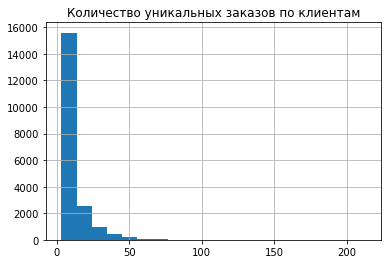

In [9]:
plt.subplot(1,1,1)
sales.groupby('user_id')['order_completed_at'].nunique().hist(bins=20);
plt.title('Количество уникальных заказов по клиентам');

In [10]:
print("Медианное кол-во заказов у одного клиента:", \
      sales.groupby('user_id')['order_completed_at'].nunique().median())

Медианное кол-во заказов у одного клиента: 6.0


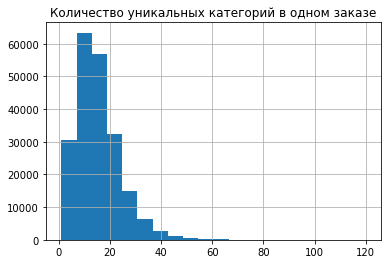

In [11]:
sales.groupby(['user_id', 'order_completed_at'])['cart'].count().hist(bins=20);
plt.title('Количество уникальных категорий в одном заказе');

In [12]:
print("Медианное кол-во заказов у одного клиента:", \
      sales.groupby('user_id')['order_completed_at'].nunique().median())

print("Медианное кол-во уникальных категорий в одном заказе:", \
sales.groupby(['user_id', 'order_completed_at'])['cart'].count().median())

print("Медианное кол-во уникальных категорий во всех заказах одного клиента:", \
sales.groupby('user_id')['cart'].nunique().median())

Медианное кол-во заказов у одного клиента: 6.0
Медианное кол-во уникальных категорий в одном заказе: 13.0
Медианное кол-во уникальных категорий во всех заказах одного клиента: 49.0


# Создадим новый признак: номер заказа клиента

In [13]:
# Создаем для каждого клиента отсортированный список дат заказов от старых к новым
order_dates = sales.groupby('user_id')['order_completed_at'].unique()
for ind in order_dates.index:
    order_dates.array[ind] = sorted(order_dates.array[ind], reverse=True)
#order_dates

In [14]:
def get_order_number(args):
    [user, order_date] = args
    return np.where(order_dates[int(user)] == order_date)[0][0]

In [15]:
# Нумеруем заказы каждого клиента в глубину (0 - последний, 1 - предпоследний и т.д.)
tstart = time.time()
sales['user_order'] = sales[['user_id', 'order_completed_at']].apply(get_order_number, axis=1)
print("{:.1f} сек.".format(time.time() - tstart))

39.6 сек.


In [16]:
sales.drop('order_completed_at', axis=1, inplace=True)
sales = sales.rename(columns={'cart': 'item_id'})
sales['target'] = 1

In [17]:
sales

,user_id,item_id,user_order,target
0,2,399,14,1
1,2,14,14,1
2,2,198,14,1
3,2,88,14,1
4,2,157,14,1
...,...,...,...,...
3123059,12702,441,0,1
3123060,12702,92,0,1
3123061,12702,431,0,1
3123062,12702,24,0,1


# Предсказание по среднему, без машинного обучения

In [18]:
# Среднее кол-во категорий в заказе каждого клиента
user_order_size = sales.groupby(['user_id', 'user_order'])['item_id'].count().reset_index()
user_mean_order_size = user_order_size.groupby('user_id')['item_id'].mean().round()

# Категории товара, наиболее часто встречающиеся в заказе клиента
user_items = sales.groupby('user_id')['item_id'].value_counts()

In [19]:
df_list = []
for user in tqdm(user_mean_order_size.index):
    items_number = int(user_mean_order_size[user])
    pred_items = user_items[user].index[:items_number]
    for item in pred_items:
        df_list.append({'user_id': user, 'item_id': item, 'target': 1})

100%|███████████████████████████████████| 20000/20000 [01:12<00:00, 274.84it/s]


In [20]:
pred_df = pd.DataFrame(df_list)
pred_df

,user_id,item_id,target
0,0,57,1
1,0,14,1
2,0,82,1
3,0,84,1
4,0,379,1
...,...,...,...
288518,19998,84,1
288519,19998,398,1
288520,19998,415,1
288521,19998,420,1


In [21]:
subm_df_my = subm.copy()
subm_df_my.drop('target', axis=1, inplace=True)
subm_df_my = subm_df_my.merge(pred_df, on=['user_id', 'item_id'], how='left')
subm_df_my['target'] = subm_df_my['target'].fillna(0).astype(int)
subm_df_my.drop(['user_id', 'item_id'], axis=1, inplace=True)
subm_df_my.to_csv(PATH + 'submission_avg.csv', index=False)

### Public score: 0.47154

# Создадим тестовый датафрейм и заполним его данными об истории покупок

In [22]:
# Сколько раз клиент ранее заказывал данную категорию
user_item_count = pd.DataFrame(sales.groupby(['user_id', 'item_id'])['target'].count()).reset_index(). \
    rename(columns={'target': 'user_item_count'})
user_item_count

,user_id,item_id,user_item_count
0,0,5,1
1,0,10,1
2,0,14,2
3,0,20,1
4,0,22,1
...,...,...,...
1117595,19998,409,1
1117596,19998,415,2
1117597,19998,420,2
1117598,19998,798,1


In [23]:
# Сколько заказов назад клиент заказывал данную категорию
user_item_distance = pd.DataFrame(sales.groupby(['user_id', 'item_id'])['user_order'].min()).reset_index(). \
    rename(columns={'user_order': 'distance_to_prev_order'})
user_item_distance['distance_to_prev_order'] += 1
user_item_count = user_item_count.merge(user_item_distance, on=['user_id', 'item_id'], how='outer')
user_item_count

,user_id,item_id,user_item_count,distance_to_prev_order
0,0,5,1,2
1,0,10,1,2
2,0,14,2,2
3,0,20,1,3
4,0,22,1,2
...,...,...,...,...
1117595,19998,409,1,1
1117596,19998,415,2,2
1117597,19998,420,2,2
1117598,19998,798,1,1


In [24]:
# Сколько всего заказов сделал данный клиент
user_orders_count = pd.DataFrame(sales.groupby('user_id')['user_order'].nunique()).reset_index(). \
    rename(columns={'user_order': 'orders_count'})
user_orders_count

,user_id,orders_count
0,0,3
1,1,9
2,2,15
3,3,7
4,4,8
...,...,...
19995,19995,3
19996,19996,3
19997,19997,3
19998,19998,3


In [25]:
# Сколько раз все клиенты заказывали данную категорию
#item_count = pd.DataFrame(sales.groupby('item_id')['target'].count()).reset_index(). \
#    rename(columns={'target': 'item_orders_count'})
#item_count

In [26]:
# Среднее количество категорий в заказе каждого клиента
ord_size_df = pd.DataFrame(sales.groupby('user_id')['user_order'].value_counts()). \
    rename(columns={'user_order': 'mean_order_size'}).reset_index()
mean_ord_size = pd.DataFrame(round(ord_size_df.groupby('user_id')['mean_order_size'].mean()))
mean_ord_size

,mean_order_size
user_id,
0,15.0
1,4.0
2,11.0
3,9.0
4,14.0
...,...
19995,3.0
19996,6.0
19997,14.0


In [27]:
# Сколько раз данная категория встречалась в 5 предыдущих заказах клиента
ord_range = [range_num for range_num in range(0, 5)]
user_item_count_5 = pd.DataFrame(sales[sales['user_order'].isin(ord_range)].groupby(['user_id', 'item_id'])['target'].sum()). \
    reset_index().rename(columns={'target': 'in_prev_5_orders'})
user_item_count_5

,user_id,item_id,in_prev_5_orders
0,0,5,1
1,0,10,1
2,0,14,2
3,0,20,1
4,0,22,1
...,...,...,...
785177,19998,409,1
785178,19998,415,2
785179,19998,420,2
785180,19998,798,1


In [28]:
test_data = subm.copy()

test_data = test_data.merge(user_orders_count, how='left', on='user_id')
test_data = test_data.merge(user_item_count, how='left', on=['user_id', 'item_id'])
# test_data['user_item_freq'] = test_data['user_item_count'] / test_data['orders_count']
# Средняя периодичность заказа клиентом данной категории
test_data['user_item_period'] = test_data['orders_count'] / test_data['user_item_count']
# Разница между расстоянием до предыдущего заказа данной категории и средней периодичностью ее заказа
test_data['distance_period_delta'] = test_data['distance_to_prev_order'] - test_data['user_item_period']
# Отношение между расстоянием до предыдущего заказа данной категории и средней периодичностью ее заказа
test_data['distance_period_ratio'] = test_data['distance_to_prev_order'] / test_data['user_item_period']

#test_data = test_data.merge(item_count, how='left', on='item_id')
#total_orders = sales.groupby(['user_id'])['user_order'].nunique().sum()
#test_data['item_orders_freq'] = test_data['item_orders_count'] / total_orders

test_data = test_data.merge(mean_ord_size, how='left', on='user_id')

test_data = test_data.merge(user_item_count_5, how='left', on=['user_id', 'item_id'])
test_data['in_prev_5_orders'] = test_data['in_prev_5_orders'].fillna(0).astype(int)

test_data.drop(['target', 'id'], axis=1, inplace=True) # , 'item_orders_count'

In [29]:
test_data

,user_id,item_id,orders_count,user_item_count,distance_to_prev_order,user_item_period,distance_period_delta,distance_period_ratio,mean_order_size,in_prev_5_orders
0,0,133,3,1,2,3.0,-1.0,0.666667,15.0,1
1,0,5,3,1,2,3.0,-1.0,0.666667,15.0,1
2,0,10,3,1,2,3.0,-1.0,0.666667,15.0,1
3,0,396,3,1,2,3.0,-1.0,0.666667,15.0,1
4,0,14,3,2,2,1.5,0.5,1.333333,15.0,2
...,...,...,...,...,...,...,...,...,...,...
790444,19998,26,3,1,3,3.0,0.0,1.000000,6.0,1
790445,19998,31,3,1,3,3.0,0.0,1.000000,6.0,1
790446,19998,29,3,1,3,3.0,0.0,1.000000,6.0,1
790447,19998,798,3,1,1,3.0,-2.0,0.333333,6.0,1


# Аналогичным образом формируем учебный датафрейм для предыдущих 10 заказов всех клиентов

In [30]:
TRAIN_ORDERS = 10
train_data = pd.DataFrame()
for order in tqdm(range(1, TRAIN_ORDERS+1)):
    subsales = sales.loc[sales['user_order'] >= order]
    # Найдем всех клиентов, у которых был заказ с данным номером
    users_with_order = set(sales[sales['user_order'] == order]['user_id'])
    user_item_count = pd.DataFrame(subsales.groupby(['user_id', 'item_id'])['target'].count()).reset_index(). \
        rename(columns={'target': 'user_item_count'})
    user_item_distance = pd.DataFrame(subsales.groupby(['user_id', 'item_id'])['user_order'].min()).reset_index(). \
        rename(columns={'user_order': 'distance_to_prev_order'})
    user_item_distance['distance_to_prev_order'] += 1 - order
    user_orders_count = pd.DataFrame(subsales.groupby('user_id')['user_order'].nunique()).reset_index(). \
        rename(columns={'user_order': 'orders_count'})
    user_item_count = user_item_count.merge(user_item_distance, on=['user_id', 'item_id'], how='outer')
    item_count = pd.DataFrame(subsales.groupby('item_id')['target'].count()).reset_index(). \
        rename(columns={'target': 'item_orders_count'})
    ord_size_df = pd.DataFrame(subsales.groupby('user_id')['user_order'].value_counts()). \
        rename(columns={'user_order': 'mean_order_size'}).reset_index()
    mean_ord_size = pd.DataFrame(round(ord_size_df.groupby('user_id')['mean_order_size'].mean()))
    
    ord_range = [range_num for range_num in range(order, order + 5)]
    user_item_count_5 = pd.DataFrame(sales[sales['user_order'].isin(ord_range)].groupby(['user_id', 'item_id'])['target'].sum()). \
        reset_index().rename(columns={'target': 'in_prev_5_orders'})
    
    train_chunk = subm.copy().drop('target', axis=1)
    train_chunk = train_chunk.merge(user_orders_count, how='left', on='user_id')
    train_chunk = train_chunk.merge(user_item_count, how='left', on=['user_id', 'item_id'])
    train_chunk = train_chunk.merge(user_item_count_5, how='left', on=['user_id', 'item_id'])
    train_chunk['in_prev_5_orders'] = train_chunk['in_prev_5_orders'].fillna(0).astype(int)
    # Возможно, у клиента ранее не было заказов
    train_chunk['orders_count'] = train_chunk['orders_count'].fillna(0).astype(int) 
    # Возможно, клиент ранее эту категорию не заказывал
    train_chunk['user_item_count'] = train_chunk['user_item_count'].fillna(0).astype(int) 
    #train_chunk['user_item_freq'] = train_chunk['user_item_count'] / train_chunk['orders_count']
    train_chunk['user_item_period'] = train_chunk['orders_count'] / train_chunk['user_item_count']
    train_chunk['distance_period_delta'] = train_chunk['distance_to_prev_order'] - train_chunk['user_item_period']
    train_chunk['distance_period_ratio'] = train_chunk['distance_to_prev_order'] / train_chunk['user_item_period']

    #train_chunk = train_chunk.merge(item_count, how='left', on='item_id')
    
    # Возможно, ранее никто эту категорию не заказывал
    #train_chunk['item_orders_count'] = train_chunk['item_orders_count'].fillna(0).astype(int) 
    #total_orders = subsales.groupby(['user_id'])['user_order'].nunique().sum()
    #train_chunk['item_orders_freq'] = train_chunk['item_orders_count'] / total_orders
    # Для заполнения признака target
    train_chunk = train_chunk.merge(sales[sales['user_order'] == order-1], how='left', \
                                    on=['user_id', 'item_id'])
    train_chunk = train_chunk.merge(mean_ord_size, how='left', on='user_id')
    train_chunk['target'] = train_chunk['target'].fillna(0).astype(int) 
    train_chunk.drop(['id', 'user_order'], axis=1, inplace=True) #'item_orders_count', 
    # Избавляемся от строк с несуществующими заказами
    train_chunk = train_chunk[train_chunk['user_id'].isin(users_with_order)]
    
    #train_chunk[train_chunk['user_item_period'] == np.inf]['user_item_period'] = -1
    train_chunk.loc[train_chunk['user_item_period'] == np.inf, 'user_item_period'] = -1
    train_chunk['distance_to_prev_order'] = train_chunk['distance_to_prev_order'].fillna(-1).astype(int)
    train_chunk['distance_period_ratio'] = train_chunk['distance_period_ratio'].fillna(-1)
    train_chunk['distance_period_delta'] = train_chunk['distance_period_delta'].fillna(1000)
    
    if order == 1: # Информацию о последних заказах каждого клиента отправляем в валидационную выборку
        valid_data = train_chunk.copy()
    else:
        train_data = pd.concat((train_data, train_chunk), axis=0)
    del train_chunk
    del subsales
    del user_item_count
    del user_orders_count
    del item_count
    
# Проверим, что в учебной выборке не осталось Nan
assert not sum(train_data.isna().sum().array) and not sum(valid_data.isna().sum().array)

100%|██████████████████████████████████████████| 10/10 [00:36<00:00,  3.64s/it]


In [31]:
for df in [train_data, valid_data, test_data]:     
    # Частота заказа данной категории за предыдущие 5 заказов клиента
    df['user_item_freq_5'] = df['in_prev_5_orders'] / df['orders_count'].map(lambda x: x if x < 5 else 5)
    # Исключаем признаки, негативно влияющие на качество модели, исходя из результатов валидации и тестовых сабмитов
    df.drop(['distance_period_ratio', 'user_item_period', 'in_prev_5_orders', 'user_item_count'], axis=1, inplace=True) # 'item_orders_freq', 

In [32]:
train_data.head()

,user_id,item_id,orders_count,distance_to_prev_order,distance_period_delta,target,mean_order_size,user_item_freq_5
0,0,133,1,-1,1000.0,1,8.0,0.0
1,0,5,1,-1,1000.0,1,8.0,0.0
2,0,10,1,-1,1000.0,1,8.0,0.0
3,0,396,1,-1,1000.0,1,8.0,0.0
4,0,14,1,1,0.0,1,8.0,1.0


In [33]:
valid_data.head()

,user_id,item_id,orders_count,distance_to_prev_order,distance_period_delta,target,mean_order_size,user_item_freq_5
0,0,133,2,1,-1.0,0,16.0,0.5
1,0,5,2,1,-1.0,0,16.0,0.5
2,0,10,2,1,-1.0,0,16.0,0.5
3,0,396,2,1,-1.0,0,16.0,0.5
4,0,14,2,1,0.0,0,16.0,1.0


In [34]:
X_train = train_data.drop('target', axis=1)
X_valid = valid_data.drop('target', axis=1)
X_test = test_data

y_train = train_data['target'].values
y_valid = valid_data['target'].values

X_all = pd.concat((X_train, X_valid), axis=0)
y_all = np.concatenate((y_train, y_valid))

In [35]:
X_train.shape, X_valid.shape, X_test.shape, X_all.shape

((5357639, 7), (790449, 7), (790449, 7), (6148088, 7))

In [36]:
len(y_train), len(y_valid), len(y_all)

(5357639, 790449, 6148088)

# Построим  и обучим модель

In [37]:
cat_cols = ['user_id', 'item_id']
cat_col_inds = [X_train.columns.get_loc(col_name) for col_name in cat_cols]

In [38]:
from catboost import CatBoostClassifier
ctb = CatBoostClassifier(depth=6, iterations=190, random_seed=SEED, eval_metric='F1')
ctb.fit(X_train, y_train, cat_features=cat_col_inds, eval_set=(X_valid, y_valid), plot=True, verbose=10)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.5
0:	learn: 0.2198665	test: 0.2341494	best: 0.2341494 (0)	total: 780ms	remaining: 2m 27s
10:	learn: 0.2931530	test: 0.3292494	best: 0.3292494 (10)	total: 6.6s	remaining: 1m 47s
20:	learn: 0.3028252	test: 0.3590227	best: 0.3590227 (20)	total: 11.9s	remaining: 1m 35s
30:	learn: 0.3035030	test: 0.3635612	best: 0.3635612 (30)	total: 17.2s	remaining: 1m 28s
40:	learn: 0.3063405	test: 0.3865210	best: 0.3865210 (40)	total: 22.4s	remaining: 1m 21s
50:	learn: 0.3081292	test: 0.3920360	best: 0.3920360 (50)	total: 27.7s	remaining: 1m 15s
60:	learn: 0.3087741	test: 0.3929904	best: 0.3930508 (58)	total: 33.2s	remaining: 1m 10s
70:	learn: 0.3094156	test: 0.3941548	best: 0.3941915 (69)	total: 38.6s	remaining: 1m 4s
80:	learn: 0.3110610	test: 0.4044312	best: 0.4044805 (78)	total: 44s	remaining: 59.2s
90:	learn: 0.3113140	test: 0.4042636	best: 0.4048497 (85)	total: 49.3s	remaining: 53.7s
100:	learn: 0.3115176	test: 0.4050031	best: 0.4057043 (96)	total: 54.7s	remaining: 48.2s
110:

In [39]:
def print_feat_imp(feat_names, feat_values, n_features=0, draw_bar=True):
    feat_imp = dict(zip(feat_names, feat_values))
    feat_dict = sorted(feat_imp.items(), key=lambda item: item[1], reverse=True)
    if not n_features:
        n_features = len(feat_values)
    { print('{}: {:.6f}'.format(k, v)) for k, v in feat_dict[:n_features] }
    
    if draw_bar:
        bar = sns.barplot(y=list(map(lambda x: x[0], feat_dict))[:n_features], \
            x=list(map(lambda x: x[1], feat_dict))[:n_features],
            orient='h');
        bar.set(title='Важность признаков согласно модели')

distance_to_prev_order: 23.382451
item_id: 23.056449
distance_period_delta: 16.842238
user_item_freq_5: 13.081465
orders_count: 11.364414
user_id: 9.685203
mean_order_size: 2.587779


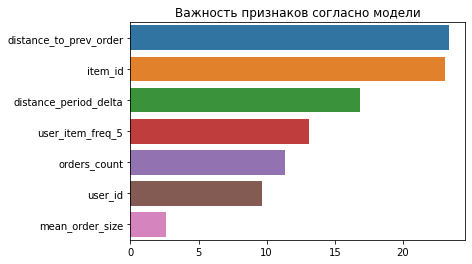

In [40]:
print_feat_imp(X_train.columns, ctb.get_feature_importance())

In [41]:
ctb.fit(X_all, y_all, cat_features=cat_col_inds, plot=True, verbose=10)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.5
0:	learn: 0.1953383	total: 730ms	remaining: 2m 17s
10:	learn: 0.3217053	total: 7.04s	remaining: 1m 54s
20:	learn: 0.3425275	total: 12.9s	remaining: 1m 43s
30:	learn: 0.3480758	total: 18.8s	remaining: 1m 36s
40:	learn: 0.3480670	total: 24.8s	remaining: 1m 30s
50:	learn: 0.3488158	total: 30.8s	remaining: 1m 23s
60:	learn: 0.3510584	total: 36.7s	remaining: 1m 17s
70:	learn: 0.3524045	total: 42.6s	remaining: 1m 11s
80:	learn: 0.3526992	total: 48.6s	remaining: 1m 5s
90:	learn: 0.3538540	total: 54.6s	remaining: 59.4s
100:	learn: 0.3545707	total: 1m	remaining: 53.4s
110:	learn: 0.3544552	total: 1m 6s	remaining: 47.5s
120:	learn: 0.3545170	total: 1m 12s	remaining: 41.4s
130:	learn: 0.3552356	total: 1m 18s	remaining: 35.4s
140:	learn: 0.3553682	total: 1m 24s	remaining: 29.4s
150:	learn: 0.3554230	total: 1m 30s	remaining: 23.4s
160:	learn: 0.3556469	total: 1m 36s	remaining: 17.4s
170:	learn: 0.3563809	total: 1m 42s	remaining: 11.4s
180:	learn: 0.3563858	total: 1m 48s	rem

In [42]:
y_pred_ctb = ctb.predict(X_test)
y_pred_proba_ctb = ctb.predict_proba(X_test)
print("Сумма предсказанных категорий заказов:", sum(y_pred_ctb))

Сумма предсказанных категорий заказов: 58719


In [17]:
#subm_df = subm.copy()
#subm_df['target'] = y_pred_ctb
#subm_df.drop(['user_id', 'item_id'], axis=1, inplace=True)
#subm_df.to_csv(PATH + 'submission_ctb.csv', index=False)

In [43]:
# Определим суммарное среднее количество заказываемых категорий по всем клиентам из тестовой выборки
mean_order = pd.DataFrame(pd.DataFrame(sales.groupby(['user_id', 'user_order'])['target'].sum()). \
    rename(columns={'target': 'mean_order'}).reset_index().groupby('user_id')['mean_order'].mean()).reset_index()
test_users = set(subm['user_id'])
mean_order_test = mean_order[mean_order['user_id'].isin(test_users)]
sum_avg = mean_order_test['mean_order'].sum().round()
print("Ожидаемая сумма предсказанных категорий заказов:", sum_avg)

Ожидаемая сумма предсказанных категорий заказов: 189636.0


In [44]:
# Отберем sum_avg пар с максимальной предсказанной вероятностью 
y_pred_proba = y_pred_proba_ctb[:, 1]
thr = sorted(y_pred_proba, reverse=True)[int(sum_avg)]
y_pred_modified = np.array([int(x>thr) for x in y_pred_proba])

In [45]:
subm_df = subm.copy()
subm_df['target'] = y_pred_modified
subm_df.drop(['user_id', 'item_id'], axis=1, inplace=True)
subm_df.to_csv(PATH + 'submission_ctb_balanced.csv', index=False)

## Public score: 0.49550

Дальнейшее повышение качества модели может быть достигнуто за счет:
- настройки параметров модели (iterations/learning_rate, bagging_temperature, random_strength)
- задания баланса классов (class_weights / scale_pos_weight)
- иной схемы перехода от предсказанных вероятностей к метке класса
- использования ансамбля моделей (несколько моделей с разными значениями параметров depth, random_seed и т.д.)